In [74]:
from qiskit_ibm_runtime import QiskitRuntimeService

token = '4c635c9b66b0ab2f37ce29d7bc33edc66f815847092ba236aa79748304b2cd4bbba6c35d8a4a6adc9b579b1990cfa8066f5220cbdc29044dc9bd59f1c1e1ea1b'
instance = 'ibm-q/open/main'

service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance=instance,
        token=token
)

# Save your IBM Quantum API key in
# ~/.qiskit/qiskit-ibm.json
service.save_account(channel="ibm_quantum", 
                                  token=token,
                                  overwrite=True)

## Define the Quantum Circuit (qc)

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister

def create_quantum_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # Apply Hadamard gate to each qubit
    for i in range(num_qubits):
        qc.h(i)
    # Apply CNOT gate between each pair of qubits
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    # Add classical registers and measurements
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

# Specify the number of qubits
num_qubits = 6  # Change this value as needed
qc = create_quantum_circuit(num_qubits)

print(qc)

      ┌───┐                    
 q_0: ┤ H ├──■─────────────────
      ├───┤┌─┴─┐               
 q_1: ┤ H ├┤ X ├──■────────────
      ├───┤└───┘┌─┴─┐          
 q_2: ┤ H ├─────┤ X ├──■───────
      ├───┤     └───┘┌─┴─┐     
 q_3: ┤ H ├──────────┤ X ├──■──
      ├───┤          └───┘┌─┴─┐
 q_4: ┤ H ├───────────────┤ X ├
      └───┘               └───┘
c4: 5/═════════════════════════
                               


### Print out the IBM Quantum details: instances and backends 
- to be used for Testing quality of backends at different qubit sizes

In [181]:
print(service.instances())
print(service.backends())

print(f"backend_names = {[backend.name for backend in service.backends()]}")

['ibm-q/open/main']
[<IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_brisbane')>]
backend_names = ['ibm_sherbrooke', 'ibm_kyiv', 'ibm_brisbane']


## Run the program across the QuantumCircuit(qc) and Backends defined above
- uses the service() account logged into at the top with the given token
- token should be saved in ~/.qiskit/

In [182]:
from qiskit_ibm_runtime import Sampler # old Sampler
#from qiskit.primitives import StatevectorSampler   # new Sampler, with quasi_dists
from qiskit.quantum_info import Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# List of backend names
backend_names = ['ibm_brisbane', 'ibm_sherbrooke', 'ibm_kyiv']  # Replace with your list of backends

def run_program(backend_name, qc):
    try:
        # Get the backendsimulator = Aer.get_backend('statevector_simulator')

        backend = service.backend(backend_name)
        # Set up pass_manager for backend
        pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

        # Run pass_manager through transpiler
        qc_transpiled = pass_manager.run(qc)

        # Run the Sampler job
        sampler = Sampler() # old Sampler
        job = sampler.run(pubs=[qc_transpiled])
        
        return job.job_id()
    
    except Exception as e:
        print(f"Error running program on backend {backend_name}: {e}")
        return None

# Run the jobs on the backends and capture job_id and backend_name
jobs_backend = []
for backend_name in backend_names:
    print(f"Submitting to: {backend_name}")
    job_id = run_program(backend_name, qc)
    if job_id:
        jobs_backend.append((job_id, backend_name))
        print(f"Job ID: {job_id}")
    else:
        print(f"Failed to submit job to {backend_name}")

print(f"jobs_backend = {jobs_backend}")

ImportError: cannot import name 'Aer' from 'qiskit' (/home/jbedell/anaconda3/envs/pyenv-eigen/lib/python3.13/site-packages/qiskit/__init__.py)

### When programs are finished, call the job_ids and compare results

In [185]:

job_id = 'cxxe56w4a290008xzse0' # old sampler style
result = service.job(job_id).result()[0] 
print(result)
print(f"{result.data.c3.get_counts()}")  # corrected access to data attribute
#print(f"{result.quasi_dists}") # new sampler style

SamplerPubResult(data=DataBin(c3=BitArray(<shape=(), num_shots=4096, num_bits=6>)), metadata={'circuit_metadata': {}})
{'111010': 66, '101111': 88, '101000': 79, '000100': 62, '000010': 76, '100000': 75, '101100': 82, '101110': 78, '111111': 68, '010111': 48, '011111': 49, '111001': 64, '011101': 42, '001110': 68, '110111': 51, '000101': 83, '101010': 74, '001000': 78, '100011': 76, '100001': 83, '110011': 48, '000110': 91, '010110': 33, '010101': 48, '100111': 89, '111110': 67, '001011': 83, '000001': 64, '001111': 77, '000111': 85, '000000': 77, '110101': 42, '110100': 47, '111100': 58, '110010': 74, '011000': 37, '011011': 54, '010010': 41, '111011': 76, '111000': 38, '011001': 51, '100101': 76, '010100': 45, '111101': 63, '001100': 70, '100100': 58, '101001': 74, '100110': 83, '101101': 76, '110110': 51, '000011': 77, '010001': 36, '010011': 37, '001101': 77, '100010': 76, '001010': 82, '110001': 59, '011100': 35, '001001': 81, '010000': 47, '011010': 54, '110000': 57, '011110': 43

        ibm_sherbrooke  ibm_brisbane  ibm_kyiv
111010        0.016113      0.017822  0.015869
101111        0.021484      0.018799  0.014648
101000        0.019287      0.010254  0.014648
000100        0.015137      0.015137  0.014648
000010        0.018555      0.012451  0.011475
...                ...           ...       ...
010000        0.011475      0.014648  0.014404
011010        0.013184      0.016602  0.014404
110000        0.013916      0.011475  0.015137
011110        0.010498      0.020996  0.015625
101011        0.016846      0.016357  0.015381

[64 rows x 3 columns]


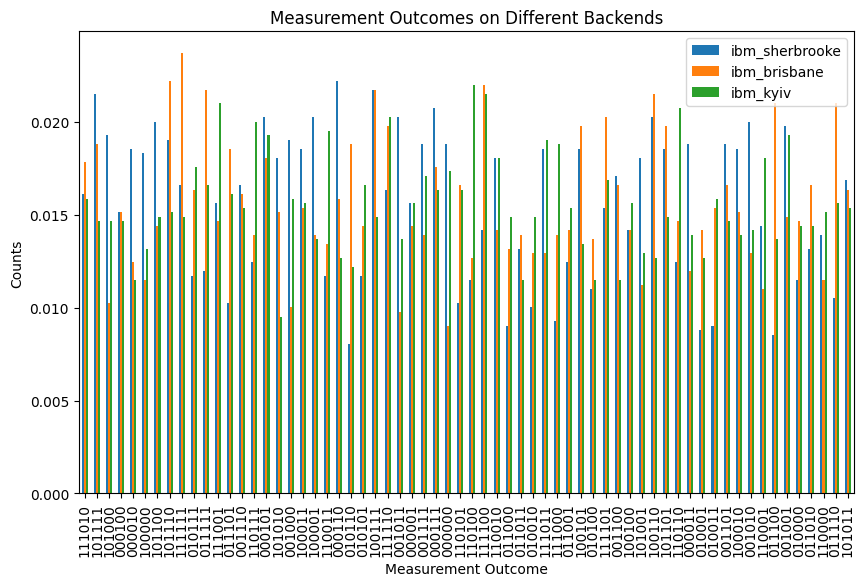

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
from qiskit.quantum_info import state_fidelity, Statevector
import time

# Normalize counts to probabilities
def normalize_counts(counts):
    total = sum(counts.values())
    return {key: val / total for key, val in counts.items()}

# Function to check job status and retrieve results
def get_job_result(job_id):
    try:
        job = service.job(job_id)
        while job.status() not in ['DONE', 'CANCELLED', 'ERROR']:
            print(f"Job {job_id} status: {job.status()}")
            time.sleep(10)  # Wait for 10 seconds before checking the status again
        if job.status() == 'DONE':
            result = job.result()
            counts = result[0].data.c3.get_counts()
            normalized_counts = normalize_counts(counts)
            return normalized_counts
        else:
            print(f"Job {job_id} failed with status: {job.status()}")
            return None
    except Exception as e:
        print(f"Error retrieving result for job {job_id}: {e}")
        return None

# Retrieve the results
results = {}
for job_id, backend_name in jobs_backend:
    counts = get_job_result(job_id)
    if counts:
        results[backend_name] = counts

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Display the results as a table
print(df)

# Plot the results
df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('Measurement Outcomes on Different Backends')
plt.show()

# Calculate and display fidelity between the results of different backends
ideal_backend = backend_names[0]
ideal_counts = results.get(ideal_backend)


In [194]:
from scipy.spatial.distance import jensenshannon

# Calculate and display Jensen-Shannon distance between the results of all backends
for i in range(len(backend_names)):
    for j in range(i + 1, len(backend_names)):
        backend_name_1 = backend_names[i]
        backend_name_2 = backend_names[j]
        if backend_name_1 in results and backend_name_2 in results:
            counts_1 = results.get(backend_name_1)
            counts_2 = results.get(backend_name_2)
            # Compare the probability distributions
            distance = jensenshannon(list(counts_1.values()), list(counts_2.values()))
            print(f"Jensen-Shannon Distance {backend_name_1} vs {backend_name_2}: {distance}")


Jensen-Shannon Distance ibm_brisbane vs ibm_sherbrooke: 0.12247247580198901
Jensen-Shannon Distance ibm_brisbane vs ibm_kyiv: 0.09032319021112371
Jensen-Shannon Distance ibm_sherbrooke vs ibm_kyiv: 0.10639794625830552
